### Load and Pre-Processing Data ###

In this step, I load the Google Stock Price dataset to preprocess the data for further analysis and model training. First, I handle the formatting inconsistencies by replacing any ',' symbols present in the data, which are often used as thousand separators. Next, I convert the relevant columns to float format. Following this, I apply normalization to scale the values between 0 and 1. Normalization is an essential step to ensure that all features contribute equally during model training, preventing features with larger numerical ranges from dominating the optimization process. This step also improves the numerical stability and convergence speed of machine learning algorithms.

In [6]:
# Read Dataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# Read dataset
train_path = "/home/hgq/Projects/DLFA3/dataset/Google_Stock_Price_Train.csv"
test_path = "/home/hgq/Projects/DLFA3/dataset/Google_Stock_Price_Test.csv"
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data = train_data[features]
test_data = test_data[features]

In [2]:

# Data Preprocessing
# Transform to float
for column in features:
    if train_data[column].dtype == 'object':
        train_data[column] = train_data[column].str.replace(',', '').astype(float)
    if test_data[column].dtype == 'object':
        test_data[column] = test_data[column].str.replace(',', '').astype(float)

# Combine train and test datasets
combined_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
combined_scaled = scaler.fit_transform(combined_data)

# Look-back window size
look_back = 30

# Create input-output pairs
X, y = [], []
for i in range(look_back, len(combined_scaled)):
    X.append(combined_scaled[i - look_back:i])  # Input: Previous `look_back` days
    y.append(combined_scaled[i])               # Output: the data of the current day
X = np.array(X)
y = np.array(y)

# Split into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_end = int(len(X) * train_ratio)
val_end = train_end + int(len(X) * val_ratio)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# Output shapes
print(f"X_train={X_train.shape}, y_train={y_train.shape}")
print(f"X_val={X_val.shape}, y_val={y_val.shape}")
print(f"X_test={X_test.shape}, y_test={y_test.shape}")


X_train=(873, 30, 5), y_train=(873, 5)
X_val=(187, 30, 5), y_val=(187, 5)
X_test=(188, 30, 5), y_test=(188, 5)


### LSTM ###

In this step that I deployed LSTM for stock prediction, I applied grid search to optimize hyperparameters such as learning rate, optimizer type, hidden layer size, number of LSTM layers, and dropout rate. Furthermore, I also utilized early stopping to prevent overfitting. Grid search evaluates all combinations of hyperparameters on the validation set, saving the best model based on the lowest validation loss. The best model is reloaded for further evaluation or testing. This approach ensures systematic exploration of hyperparameters for optimal performance.

In [2]:
#LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform to PyTorch Tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

# LSTM Model with Dropout
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Dropout on the last hidden state
        out = self.fc(out)
        return out

# Hyperparameter Grid
param_grid = {
    "learning_rate": [0.005, 0.001, 0.0005, 0.0001],
    "optimizer": ["adam", "sgd", "adamw"],
    "hidden_size": [16, 32, 64, 128],
    "num_layers": [1, 2, 3],
    "dropout": [0.0, 0.2, 0.5]
}

# Generate all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))
best_val_loss = float("inf")
best_params = None

# Grid Search
for params in param_combinations:
    learning_rate, optimizer_name, hidden_size, num_layers, dropout = params

    print(f"Testing parameters: lr={learning_rate}, optimizer={optimizer_name}, hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}")

    # Initialize model
    model = MyLSTM(input_size=5, hidden_size=hidden_size, num_layers=num_layers, output_size=5, dropout=dropout).to(device)
    criterion = nn.MSELoss()

    # Initialize optimizer
    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Early Stopping
    patience = 5
    early_stop_counter = 0
    best_model_val_loss = float("inf")

    # Training Loop
    for epoch in range(50):  # Max epochs
        model.train()
        train_loss = 0.0

        for i in range(0, len(X_train), 32):  # Batch size = 32
            x_batch = X_train[i:i+32]
            y_batch = y_train[i:i+32]

            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(X_train) / 32  # Average train loss

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()

        print(f"Epoch [{epoch+1}/50], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early Stopping Check
        if val_loss < best_model_val_loss:
            best_model_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    # Update best parameters if current combination is better
    if best_model_val_loss < best_val_loss:
        best_val_loss = best_model_val_loss
        best_params = params
        # Save best model
        torch.save(model.state_dict(), "best_model.pth")

print(f"Best Parameters: {best_params}, Best Validation Loss: {best_val_loss:.4f}")

# Load Best Model
model = MyLSTM(
    input_size=5,
    hidden_size=best_params[2],
    num_layers=best_params[3],
    output_size=5,
    dropout=best_params[4]
).to(device)
model.load_state_dict(torch.load("best_model.pth"))
print("Best model loaded.")


Testing parameters: lr=0.001, optimizer=adam, hidden_size=16, num_layers=1, dropout=0.0
Epoch [1/50], Train Loss: 0.1448, Val Loss: 0.2135
Epoch [2/50], Train Loss: 0.0639, Val Loss: 0.0429
Epoch [3/50], Train Loss: 0.0418, Val Loss: 0.0474
Epoch [4/50], Train Loss: 0.0314, Val Loss: 0.0433
Epoch [5/50], Train Loss: 0.0275, Val Loss: 0.0353
Epoch [6/50], Train Loss: 0.0243, Val Loss: 0.0283
Epoch [7/50], Train Loss: 0.0212, Val Loss: 0.0229
Epoch [8/50], Train Loss: 0.0184, Val Loss: 0.0190
Epoch [9/50], Train Loss: 0.0158, Val Loss: 0.0162
Epoch [10/50], Train Loss: 0.0129, Val Loss: 0.0151
Epoch [11/50], Train Loss: 0.0098, Val Loss: 0.0113
Epoch [12/50], Train Loss: 0.0074, Val Loss: 0.0064
Epoch [13/50], Train Loss: 0.0065, Val Loss: 0.0047
Epoch [14/50], Train Loss: 0.0049, Val Loss: 0.0049
Epoch [15/50], Train Loss: 0.0045, Val Loss: 0.0028
Epoch [16/50], Train Loss: 0.0105, Val Loss: 0.0058
Epoch [17/50], Train Loss: 0.0035, Val Loss: 0.0024
Epoch [18/50], Train Loss: 0.0050, Va

Therefore, the best parameters is: Best Parameters: (lr = 0.0005, optimizer = 'adam', hidden_size:64, num_layers = 1, best_dropout = 0.5) with the Validation Loss: 0.0017

Next step, I will used this best model to assess the model performance on the test dataset.

Open - MSE: 0.0013, MAE: 0.0317, R²: 0.7000


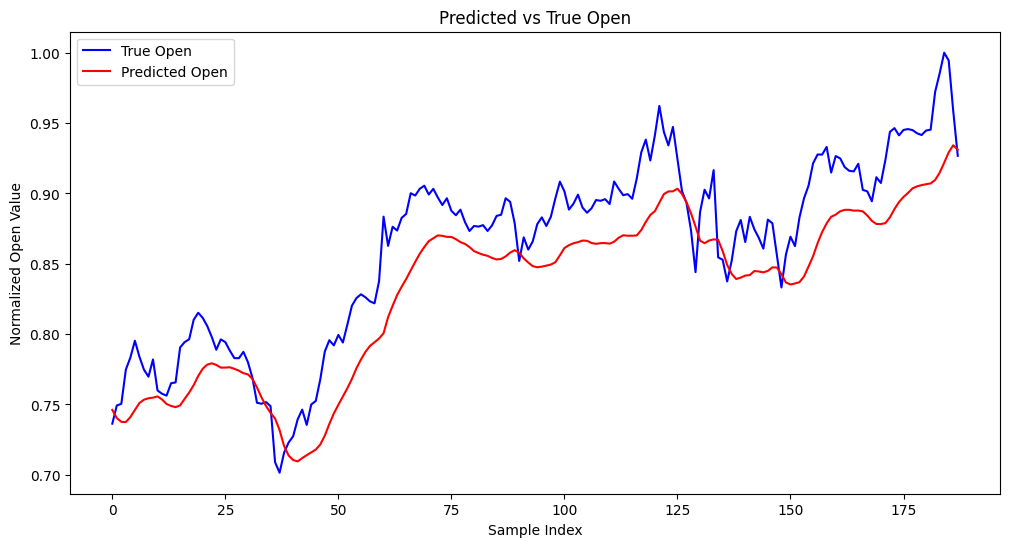

High - MSE: 0.0024, MAE: 0.0452, R²: 0.4148


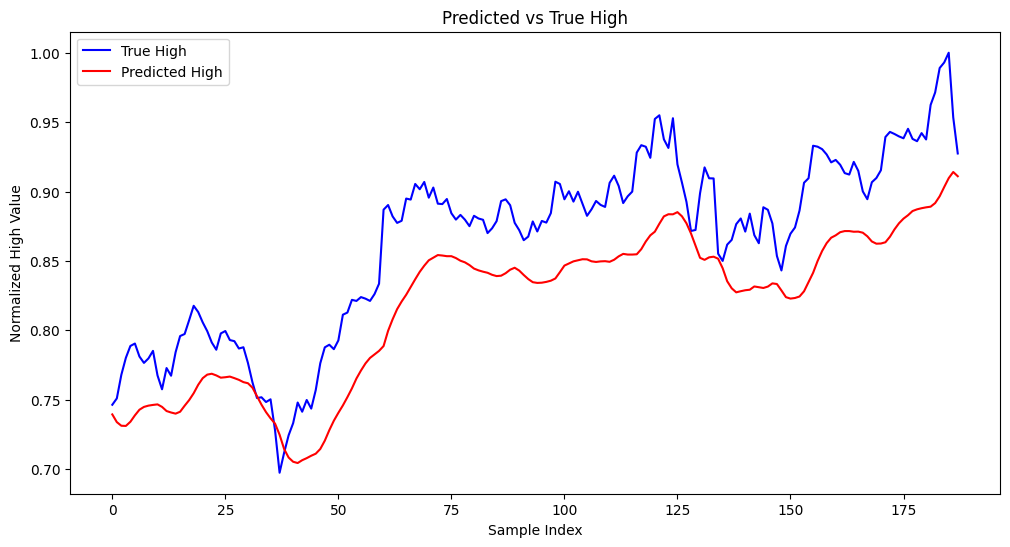

Low - MSE: 0.0022, MAE: 0.0425, R²: 0.4953


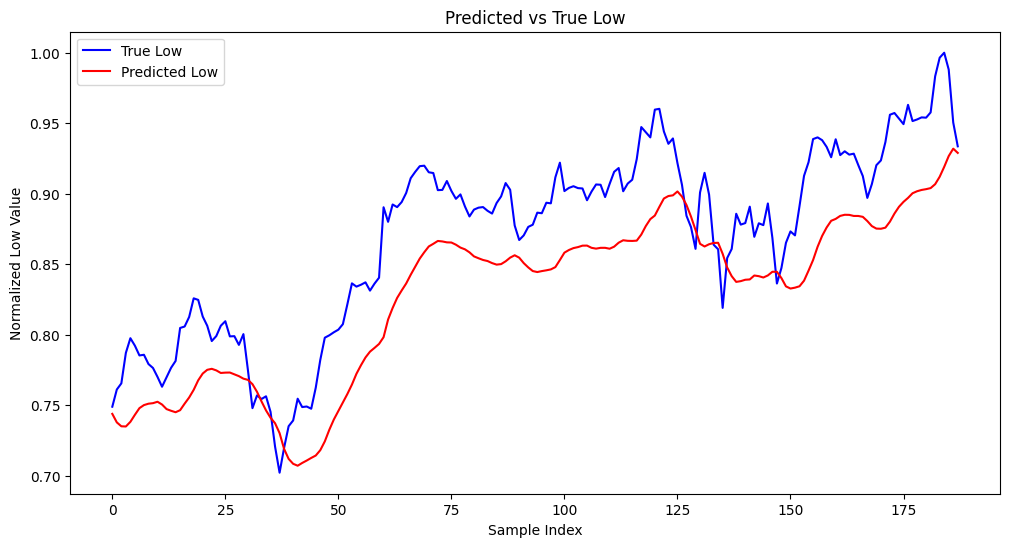

Close - MSE: 0.0614, MAE: 0.2453, R²: -23.8826


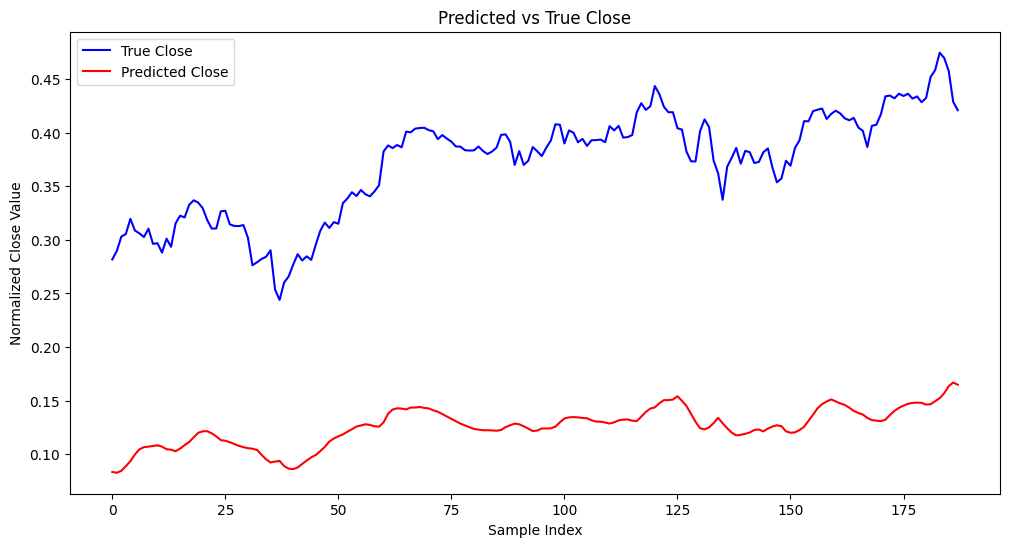

Volume - MSE: 0.0016, MAE: 0.0296, R²: -1.1215


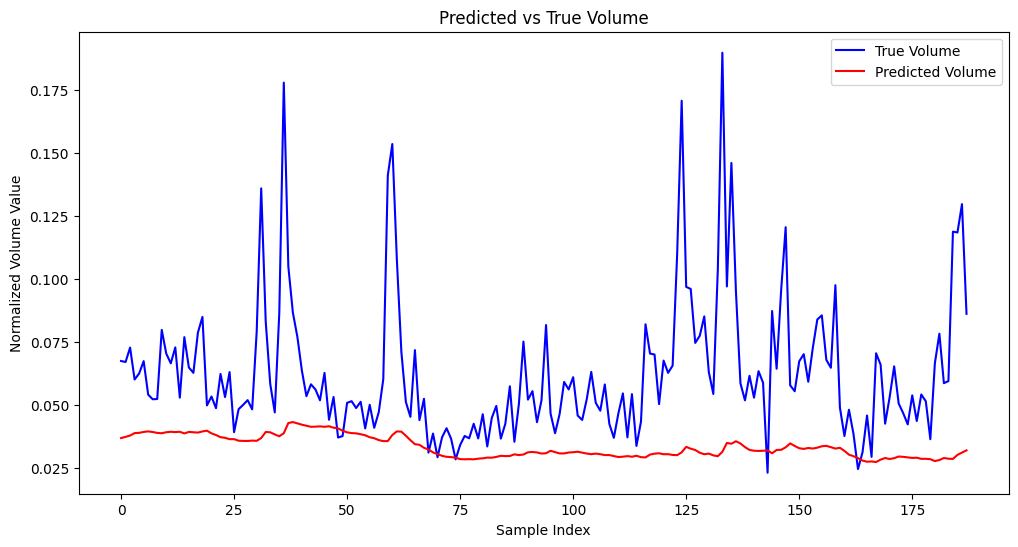


Overall Metrics (All Features):
Mean Squared Error (MSE): 0.0138
Mean Absolute Error (MAE): 0.0789
R² Score: -4.6788


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_lr, best_optimizer_name, best_hidden_size, best_num_layers, best_dropout = best_params
model = MyLSTM(
    input_size=5,
    hidden_size=best_hidden_size,
    num_layers=best_num_layers,
    output_size=5,
    dropout=best_dropout
).to(device)
model.load_state_dict(torch.load("best_model.pth"))

# Test
model.eval()

# Transform to PyTorch Tensor
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

with torch.no_grad():
    predictions = model(X_test)

# Transform prediction and true to NumPy
predictions = predictions.cpu().numpy()
y_test = y_test.cpu().numpy()

features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Calculate metrics
for i, feature in enumerate(features):
    mse = mean_squared_error(y_test[:, i], predictions[:, i])
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    r2 = r2_score(y_test[:, i], predictions[:, i])
    print(f"{feature} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Plot Charts
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, i], label=f"True {feature}", color="blue")
    plt.plot(predictions[:, i], label=f"Predicted {feature}", color="red")
    plt.title(f"Predicted vs True {feature}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"Normalized {feature} Value")
    plt.legend()
    plt.show()

# Total Metrics
mse_total = mean_squared_error(y_test, predictions)
mae_total = mean_absolute_error(y_test, predictions)
r2_total = r2_score(y_test, predictions)

print("\nOverall Metrics (All Features):")
print(f"Mean Squared Error (MSE): {mse_total:.4f}")
print(f"Mean Absolute Error (MAE): {mae_total:.4f}")
print(f"R² Score: {r2_total:.4f}")


These tables indicates that the model have a good performance on predicitng close, high, and open, but did bad in volume and close. Howeverm, I design the LSTM for the next 1 day prediction base on previous 30 days, which means that this model works for those people that want to make a decision to sell or keep the stock. By predicting close, high and open is enough to make such a decision.

Next I will also compare to other model.

###  Vanilla RNN ###

In [6]:
# Transform to PyTorch Tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)


# Vanilla RNN Model
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.dropout(out[:, -1, :])  # Dropout on the last hidden state
        out = self.fc(out)
        return out

# Hyperparameter Grid
param_grid = {
    "learning_rate": [0.005, 0.001, 0.0005, 0.0001],
    "optimizer": ["adam", "sgd", "adamw"],
    "hidden_size": [16, 32, 64, 128],
    "num_layers": [1, 2, 3],
    "dropout": [0.0, 0.2, 0.5]
}

# Generate all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))
best_val_loss = float("inf")
best_params_RNN = None

# Grid Search
for params in param_combinations:
    learning_rate, optimizer_name, hidden_size, num_layers, dropout = params

    print(f"Testing parameters: lr={learning_rate}, optimizer={optimizer_name}, hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}")

    # Initialize model
    model = MyRNN(input_size=5, hidden_size=hidden_size, num_layers=num_layers, output_size=5, dropout=dropout).to(device)
    criterion = nn.MSELoss()

    # Initialize optimizer
    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Early Stopping
    patience = 5
    early_stop_counter = 0
    best_model_val_loss = float("inf")

    # Training Loop
    for epoch in range(50):  # Max epochs
        model.train()
        train_loss = 0.0

        for i in range(0, len(X_train), 32):  # Batch size = 32
            x_batch = X_train[i:i+32]
            y_batch = y_train[i:i+32]

            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(X_train) / 32  # Average train loss

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()

        print(f"Epoch [{epoch+1}/50], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early Stopping Check
        if val_loss < best_model_val_loss:
            best_model_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    # Update best parameters if current combination is better
    if best_model_val_loss < best_val_loss:
        best_val_loss = best_model_val_loss
        best_params_RNN = params
        # Save best model
        torch.save(model.state_dict(), "best_model_RNN.pth")

print(f"Best Parameters: {best_params_RNN}, Best Validation Loss: {best_val_loss:.4f}")



Testing parameters: lr=0.005, optimizer=adam, hidden_size=16, num_layers=1, dropout=0.0
Epoch [1/50], Train Loss: 0.0355, Val Loss: 0.0404
Epoch [2/50], Train Loss: 0.0379, Val Loss: 0.0197
Epoch [3/50], Train Loss: 0.0263, Val Loss: 0.0138
Epoch [4/50], Train Loss: 0.0242, Val Loss: 0.0200
Epoch [5/50], Train Loss: 0.0130, Val Loss: 0.0035
Epoch [6/50], Train Loss: 0.0048, Val Loss: 0.0072
Epoch [7/50], Train Loss: 0.0050, Val Loss: 0.0131
Epoch [8/50], Train Loss: 0.0032, Val Loss: 0.0060
Epoch [9/50], Train Loss: 0.0029, Val Loss: 0.0018
Epoch [10/50], Train Loss: 0.0025, Val Loss: 0.0035
Epoch [11/50], Train Loss: 0.0025, Val Loss: 0.0059
Epoch [12/50], Train Loss: 0.0018, Val Loss: 0.0011
Epoch [13/50], Train Loss: 0.0026, Val Loss: 0.0030
Epoch [14/50], Train Loss: 0.0022, Val Loss: 0.0046
Epoch [15/50], Train Loss: 0.0016, Val Loss: 0.0010
Epoch [16/50], Train Loss: 0.0017, Val Loss: 0.0020
Epoch [17/50], Train Loss: 0.0017, Val Loss: 0.0022
Epoch [18/50], Train Loss: 0.0016, Va

Open - MSE: 0.0006, MAE: 0.0210, R²: 0.8555


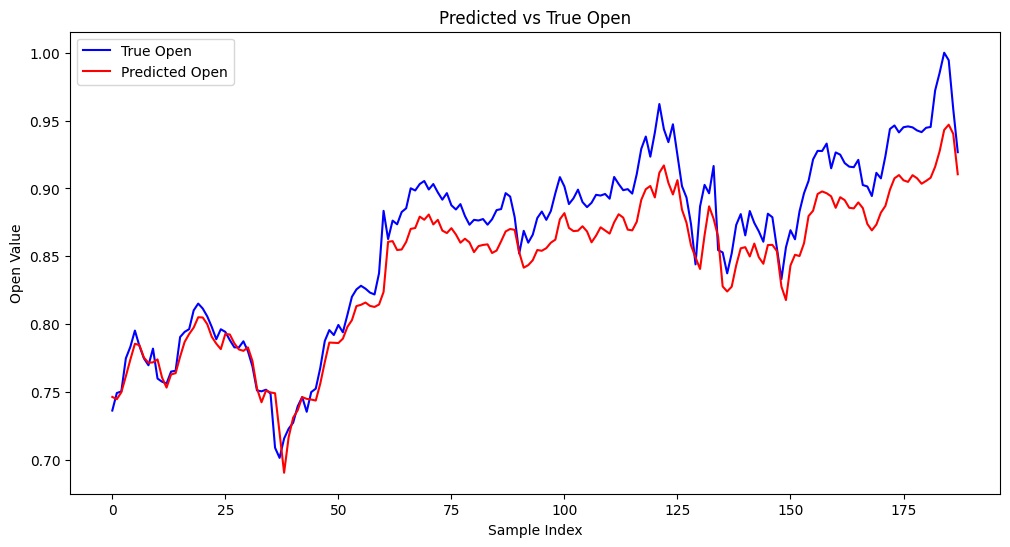

High - MSE: 0.0038, MAE: 0.0577, R²: 0.0956


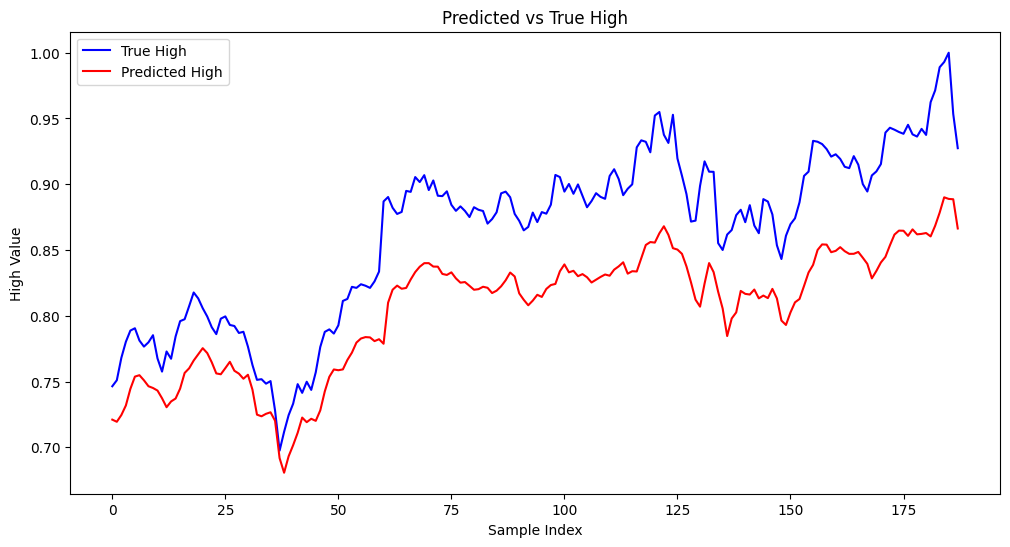

Low - MSE: 0.0010, MAE: 0.0276, R²: 0.7720


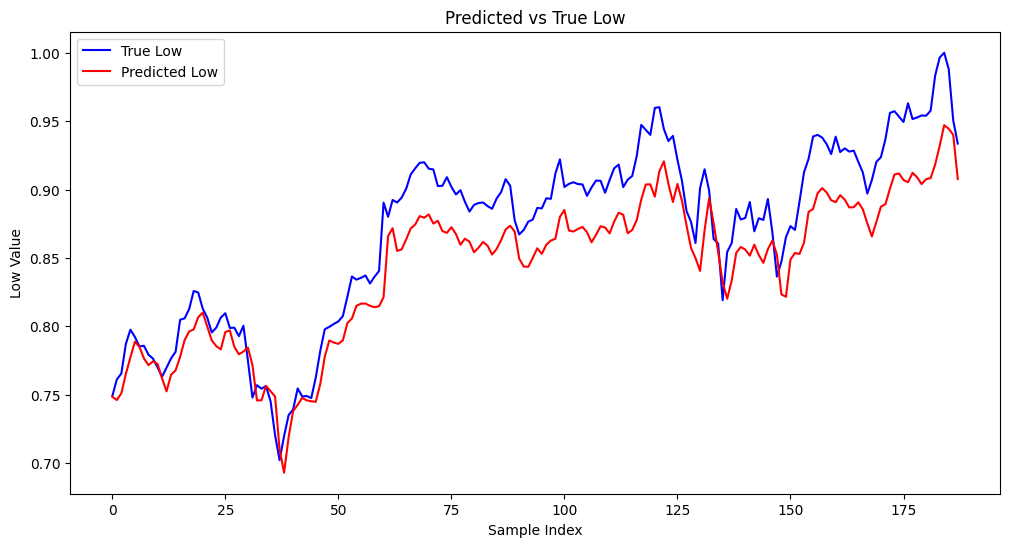

Close - MSE: 0.0017, MAE: 0.0388, R²: 0.3221


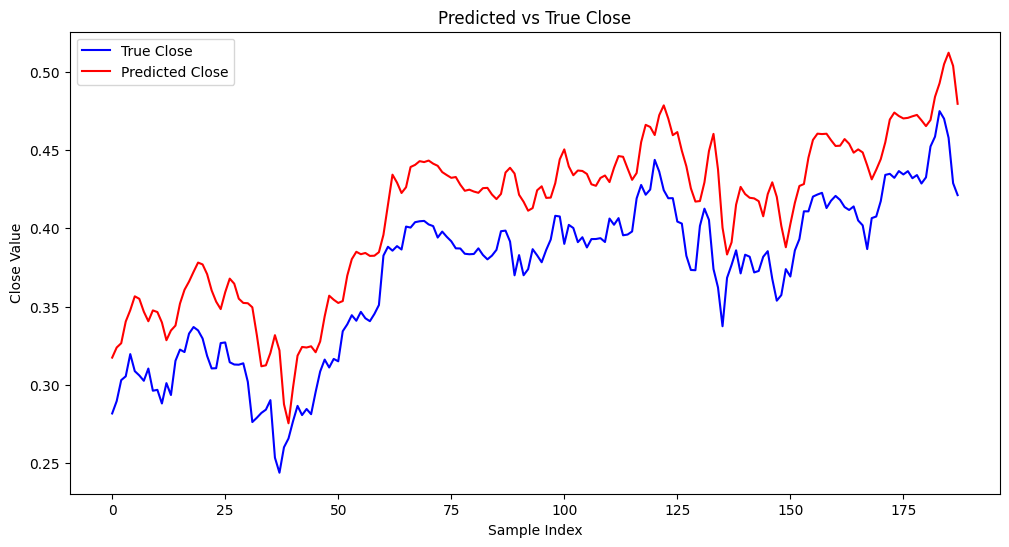

Volume - MSE: 0.0023, MAE: 0.0422, R²: -2.1018


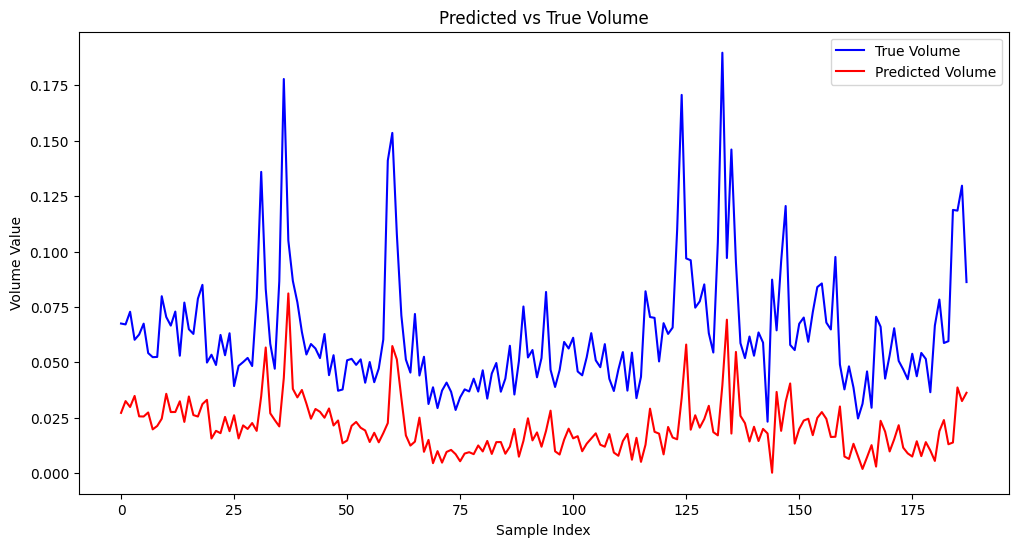


Overall Metrics (All Features):
Mean Squared Error (MSE): 0.0019
Mean Absolute Error (MAE): 0.0375
R² Score: -0.0113


In [7]:
# Load Best Model
best_lr, best_optimizer_name, best_hidden_size, best_num_layers, best_dropout = best_params_RNN
model = MyRNN(
    input_size=5,
    hidden_size=best_hidden_size,
    num_layers=best_num_layers,
    output_size=5,
    dropout=best_dropout
).to(device)

# Load the saved state_dict
model.load_state_dict(torch.load("best_model_RNN.pth"))
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

with torch.no_grad():
    predictions_tensor = model(X_test_tensor)
predictions = predictions_tensor.cpu().numpy()
y_test = y_test_tensor.cpu().numpy()

for i, feature in enumerate(features):
    mse = mean_squared_error(y_test[:, i], predictions[:, i])
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    r2 = r2_score(y_test[:, i], predictions[:, i])
    print(f"{feature} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Plot RNN Charts
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, i], label=f"True {feature}", color="blue")
    plt.plot(predictions[:, i], label=f"Predicted {feature}", color="red")
    plt.title(f"Predicted vs True {feature}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{feature} Value")
    plt.legend()
    plt.show()

mse_total = mean_squared_error(y_test, predictions)
mae_total = mean_absolute_error(y_test, predictions)
r2_total = r2_score(y_test, predictions)

print("\nOverall Metrics (All Features):")
print(f"Mean Squared Error (MSE): {mse_total:.4f}")
print(f"Mean Absolute Error (MAE): {mae_total:.4f}")
print(f"R² Score: {r2_total:.4f}")


### GRU ###

In [4]:
# Transform to PyTorch Tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

# GRU Model
class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(MyGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])  # Dropout on the last hidden state
        out = self.fc(out)
        return out

# Hyperparameter Grid
param_grid = {
    "learning_rate": [0.005, 0.001, 0.0005, 0.0001],
    "optimizer": ["adam", "sgd", "adamw"],
    "hidden_size": [16, 32, 64, 128],
    "num_layers": [1, 2, 3],
    "dropout": [0.0, 0.2, 0.5]
}

# Generate all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))
best_val_loss = float("inf")
best_params_GRU = None

# Grid Search
for params in param_combinations:
    learning_rate, optimizer_name, hidden_size, num_layers, dropout = params

    print(f"Testing parameters: lr={learning_rate}, optimizer={optimizer_name}, hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}")

    # Initialize model
    model = MyGRU(input_size=5, hidden_size=hidden_size, num_layers=num_layers, output_size=5, dropout=dropout).to(device)
    criterion = nn.MSELoss()

    # Initialize optimizer
    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Early Stopping
    patience = 5
    early_stop_counter = 0
    best_model_val_loss = float("inf")

    # Training Loop
    for epoch in range(50):  # Max epochs
        model.train()
        train_loss = 0.0

        for i in range(0, len(X_train), 32):  # Batch size = 32
            x_batch = X_train[i:i+32]
            y_batch = y_train[i:i+32]

            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(X_train) / 32  # Average train loss

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()

        print(f"Epoch [{epoch+1}/50], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early Stopping Check
        if val_loss < best_model_val_loss:
            best_model_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    # Update best parameters if current combination is better
    if best_model_val_loss < best_val_loss:
        best_val_loss = best_model_val_loss
        best_params_GRU = params
        # Save best model
        torch.save(model.state_dict(), "best_model_GRU.pth")

print(f"Best Parameters: {best_params_GRU}, Best Validation Loss: {best_val_loss:.4f}")


Testing parameters: lr=0.005, optimizer=adam, hidden_size=16, num_layers=1, dropout=0.0
Epoch [1/50], Train Loss: 0.0585, Val Loss: 0.0221
Epoch [2/50], Train Loss: 0.0485, Val Loss: 0.0274
Epoch [3/50], Train Loss: 0.0252, Val Loss: 0.0145
Epoch [4/50], Train Loss: 0.0132, Val Loss: 0.0051
Epoch [5/50], Train Loss: 0.0072, Val Loss: 0.0155
Epoch [6/50], Train Loss: 0.0036, Val Loss: 0.0078
Epoch [7/50], Train Loss: 0.0039, Val Loss: 0.0051
Epoch [8/50], Train Loss: 0.0031, Val Loss: 0.0033
Epoch [9/50], Train Loss: 0.0032, Val Loss: 0.0128
Epoch [10/50], Train Loss: 0.0024, Val Loss: 0.0058
Epoch [11/50], Train Loss: 0.0031, Val Loss: 0.0025
Epoch [12/50], Train Loss: 0.0029, Val Loss: 0.0031
Epoch [13/50], Train Loss: 0.0039, Val Loss: 0.0171
Epoch [14/50], Train Loss: 0.0025, Val Loss: 0.0058
Epoch [15/50], Train Loss: 0.0034, Val Loss: 0.0029
Epoch [16/50], Train Loss: 0.0028, Val Loss: 0.0017
Epoch [17/50], Train Loss: 0.0039, Val Loss: 0.0164
Epoch [18/50], Train Loss: 0.0028, Va

Open - MSE: 0.0005, MAE: 0.0183, R²: 0.8849


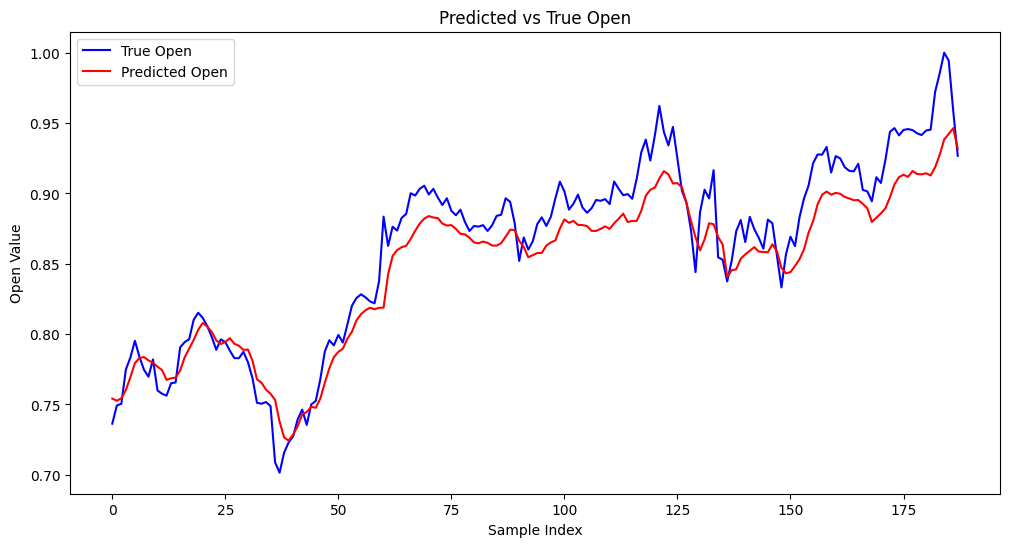

High - MSE: 0.0006, MAE: 0.0199, R²: 0.8577


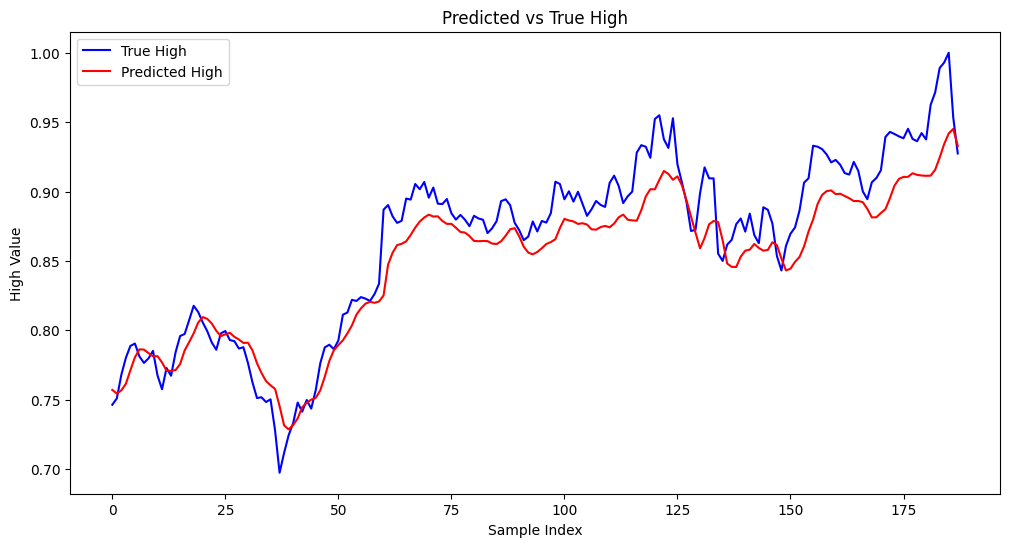

Low - MSE: 0.0003, MAE: 0.0150, R²: 0.9196


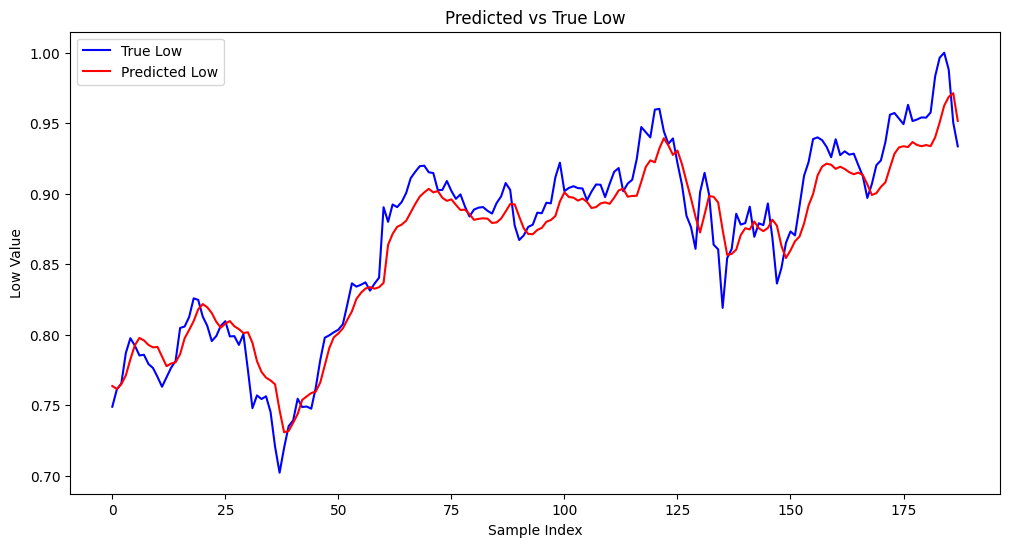

Close - MSE: 0.0002, MAE: 0.0111, R²: 0.9223


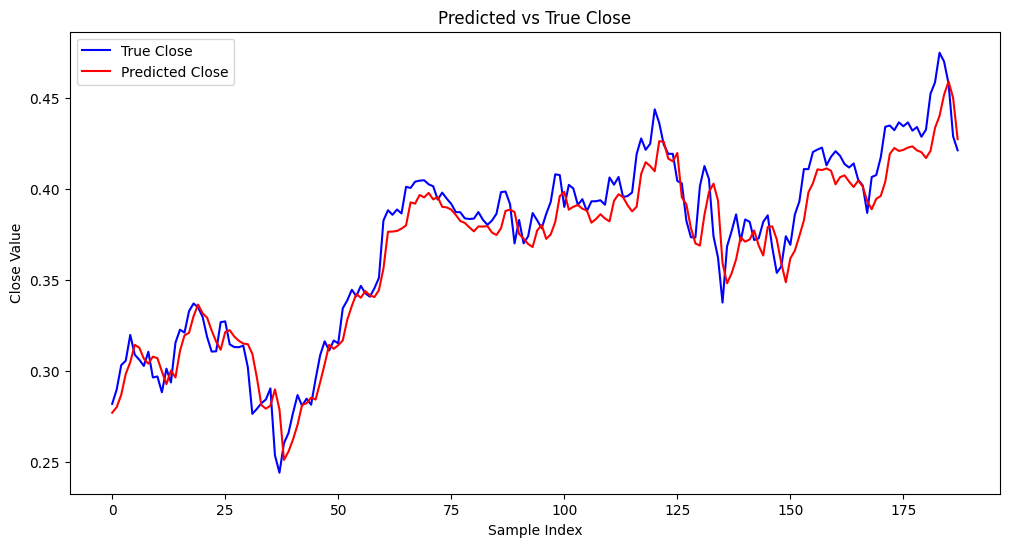

Volume - MSE: 0.0014, MAE: 0.0288, R²: -0.8167


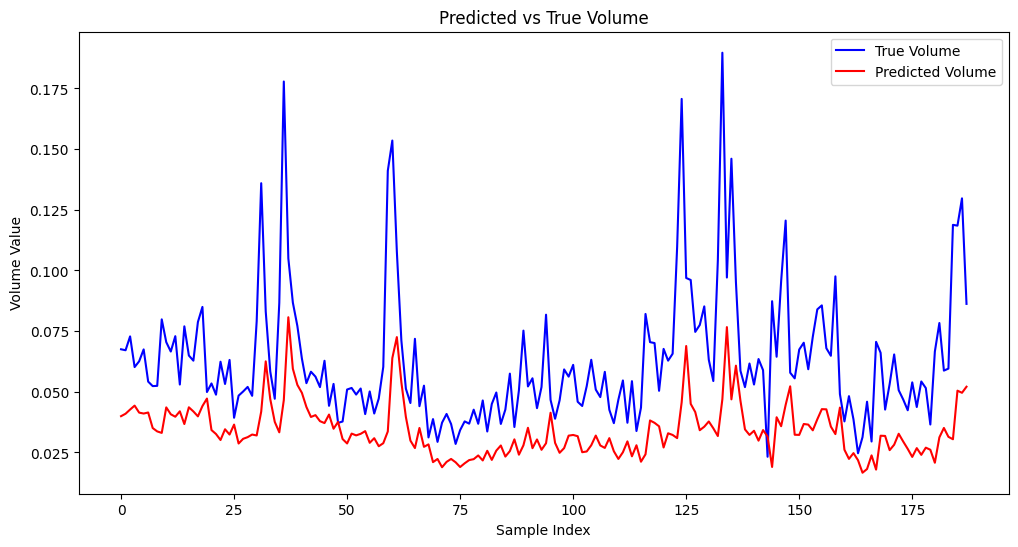


Overall Metrics (All Features):
Mean Squared Error (MSE): 0.0006
Mean Absolute Error (MAE): 0.0186
R² Score: 0.5536


In [7]:
# Load Best Model
best_lr, best_optimizer_name, best_hidden_size, best_num_layers, best_dropout = best_params_GRU
model = MyGRU(
    input_size=5,
    hidden_size=best_hidden_size,
    num_layers=best_num_layers,
    output_size=5,
    dropout=best_dropout
).to(device)

# Load the saved state_dict
model.load_state_dict(torch.load("best_model_GRU.pth"))
model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

with torch.no_grad():
    predictions_tensor = model(X_test_tensor)

predictions = predictions_tensor.cpu().numpy()
y_test = y_test_tensor.cpu().numpy()


features = ['Open', 'High', 'Low', 'Close', 'Volume']

for i, feature in enumerate(features):
    mse = mean_squared_error(y_test[:, i], predictions[:, i])
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    r2 = r2_score(y_test[:, i], predictions[:, i])
    print(f"{feature} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, i], label=f"True {feature}", color="blue")
    plt.plot(predictions[:, i], label=f"Predicted {feature}", color="red")
    plt.title(f"Predicted vs True {feature}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{feature} Value")
    plt.legend()
    plt.show()

mse_total = mean_squared_error(y_test, predictions)
mae_total = mean_absolute_error(y_test, predictions)
r2_total = r2_score(y_test, predictions)

print("\nOverall Metrics (All Features):")
print(f"Mean Squared Error (MSE): {mse_total:.4f}")
print(f"Mean Absolute Error (MAE): {mae_total:.4f}")
print(f"R² Score: {r2_total:.4f}")


### Conclusion ###

Overall, the GRU model was the most consistent and performed the best across most features, demonstrating its ability to handle sequential data well without succumbing to the vanishing gradient problem as significantly as the LSTM model. The Vanilla RNN also showed decent performance, particularly with the "Open" and "Low" features, benefiting from its simplicity and being less prone to overfitting, especially given the relatively straightforward structure of this dataset. The LSTM model, while theoretically capable of capturing long-term dependencies, appeared to struggle with the simplicity and length of this dataset, leading to poor performance, especially in predicting "Close" and "Volume." This might indicate overfitting or an inability to handle the specific short time dependencies present in the dataset.